In [1]:
# Installing packages
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

In [2]:
# Creating CNN model class for the task. Here, we are using VGG19 model.

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # Choose convolutional outputs conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 as mentioned in NST paper
        self.chosen_features = ['0', '5', '10', '19', '28']

        # Removing the layers and classification network from VGG19
        self.model = models.vgg19(pretrained=True).features[:29]
        
    def forward(self, x):
        features = []

        # Go through each layer in model, if the layer is in the chosen_features, store it in features. At the end we'll just return all the activations
        # for the specific layers we have in chosen_features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
model = VGG().to(device).eval()
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 255MB/s]


VGG(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [3]:
image_size = 256

# Defining necessary transformations
loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [4]:
# Loading necessary images and applying transformations

original_image = load_image("emma watson.jpg")
style_image = load_image("edvard munch.jpg")

In [5]:
# initialized generated as original image.
# Can be initialised as random but to get better and faster results we took original image

generated = original_image.clone().requires_grad_(True)

In [6]:
# Hyperparameters

total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr = learning_rate)

In [7]:
for step in range(total_steps):

    # Obtaining the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_features = model(original_image)
    style_features = model(style_image)
    
    style_loss = original_loss = 0
    
    for gen, orig, style in zip(generated_features, original_features, style_features):
        batch_size, channel, height, width = gen.shape
        original_loss += torch.mean((gen-orig))
        
        # Compute Gram Matrix of generated
        G = gen.view(channel, height*width).mm(gen.view(channel, height*width).t())
        # Compute Gram Matrix of style
        A = style.view(channel, height*width).mm(style.view(channel, height*width).t())

        style_loss += torch.mean((G-A)**2)

        # Define loss as combination of original loss and style loss
        #               - keeping style loss less important as we took original image as generated and we only want to copy artistic style.
        total_loss = alpha*original_loss + beta*style_loss
        optimizer.zero_grad()
        total_loss.backward(retain_graph = True)
        optimizer.step()
        
        if step%1000 == 999:
            print(total_loss)
            save_image(generated, "generated.png")

tensor(319.4814, device='cuda:0', grad_fn=<AddBackward0>)
tensor(489.3119, device='cuda:0', grad_fn=<AddBackward0>)
tensor(876.3770, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1340.1654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1850.7078, device='cuda:0', grad_fn=<AddBackward0>)
tensor(219.0672, device='cuda:0', grad_fn=<AddBackward0>)
tensor(357.6930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(675.3033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1035.1738, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1425.3817, device='cuda:0', grad_fn=<AddBackward0>)
tensor(162.5514, device='cuda:0', grad_fn=<AddBackward0>)
tensor(266.1262, device='cuda:0', grad_fn=<AddBackward0>)
tensor(530.8607, device='cuda:0', grad_fn=<AddBackward0>)
tensor(877.9341, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1298.9922, device='cuda:0', grad_fn=<AddBackward0>)
tensor(122.9813, device='cuda:0', grad_fn=<AddBackward0>)
tensor(243.5526, device='cuda:0', grad_fn=<AddBackward0>)
tensor(58

In [1]:
import matplotlib.pyplot as plt
import PIL

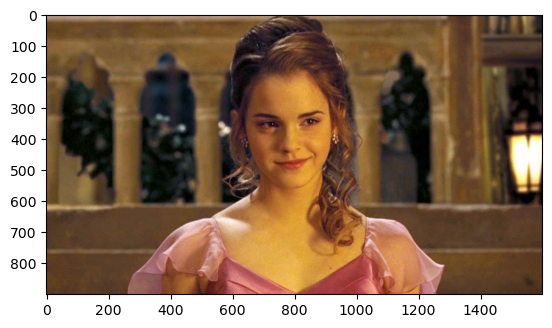

In [2]:
# Visualizing original, style and resulted images

original_image = PIL.Image.open("emma watson.jpg")
plt.imshow(original_image)

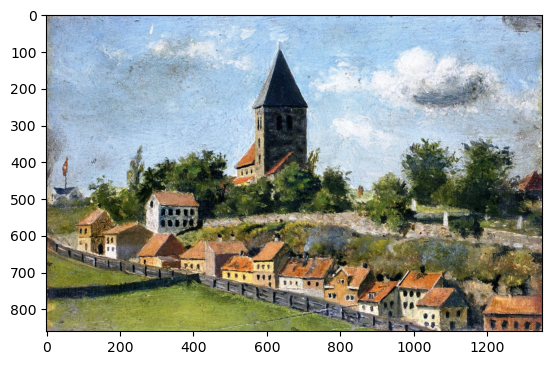

In [3]:
style_image = PIL.Image.open("edvard munch.jpg")
plt.imshow(style_image)

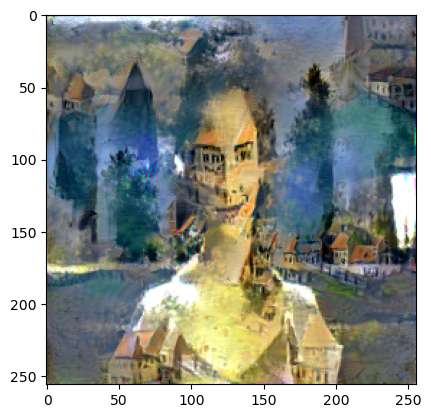

In [4]:
generated_image = PIL.Image.open("generated.png")
plt.imshow(generated_image)